# Exploring ACLED data

In [1]:
# African dataset
# https://www.acleddata.com/curated-data-files/

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Exporting excel file as json

In [3]:
# import excel file
# df = pd.read_excel('../data/Africa_1997-2019_Oct12-1.xlsx')

In [4]:
# df.shape

In [5]:
# New column for date
# df['date'] = pd.to_datetime(df['EVENT_DATE']).dt.date

In [6]:
# export dataframe as json
# df.to_json('../data/africa-data.json')

## Importing data

In [7]:
df = pd.read_json('../data/africa-data.json')

In [8]:
df.shape

(193565, 30)

## Data formatting

In [11]:
# df.iloc[0]

In [12]:
# columns to keep
columns = ['YEAR', 'EVENT_TYPE', 'SUB_EVENT_TYPE', 'ACTOR1', 'REGION', 'COUNTRY', 'SOURCE', 'FATALITIES', 'date']

In [21]:
try:
    df = df[columns]
    df.columns = ['year', 'event_type', 'sub_event_type', 'actor', 'region', 'country', 'source', 'fatalities', 'date']
except KeyError as e:
    print(e)
    pass

df.columns

"['YEAR' 'EVENT_TYPE' 'SUB_EVENT_TYPE' 'ACTOR1' 'REGION' 'COUNTRY' 'SOURCE'\n 'FATALITIES'] not in index"


Index(['year', 'event_type', 'sub_event_type', 'actor', 'region', 'country',
       'source', 'fatalities', 'date'],
      dtype='object')

## Data exploration

In [22]:
# Plot variables sns
plt.rcParams['figure.figsize'] = (15, 8)

In [23]:
print('Event types: {}\n'.format(df['event_type'].unique()))
print('Event subtypes: {}'.format(df['sub_event_type'].unique()))

Event types: ['Violence against civilians' 'Explosions/Remote violence'
 'Strategic developments' 'Battles' 'Protests' 'Riots']

Event subtypes: ['Attack' 'Remote explosive/landmine/IED' 'Abduction/forced disappearance'
 'Non-violent transfer of territory' 'Armed clash'
 'Looting/property destruction' 'Headquarters or base established'
 'Peaceful protest' 'Non-state actor overtakes territory'
 'Government regains territory' 'Protest with intervention'
 'Change to group/activity' 'Mob violence' 'Violent demonstration'
 'Sexual violence' 'Arrests' 'Air/drone strike'
 'Shelling/artillery/missile attack' 'Disrupted weapons use'
 'Excessive force against protesters' 'Agreement' 'Other' 'Grenade'
 'Suicide bomb' 'Chemical weapon']


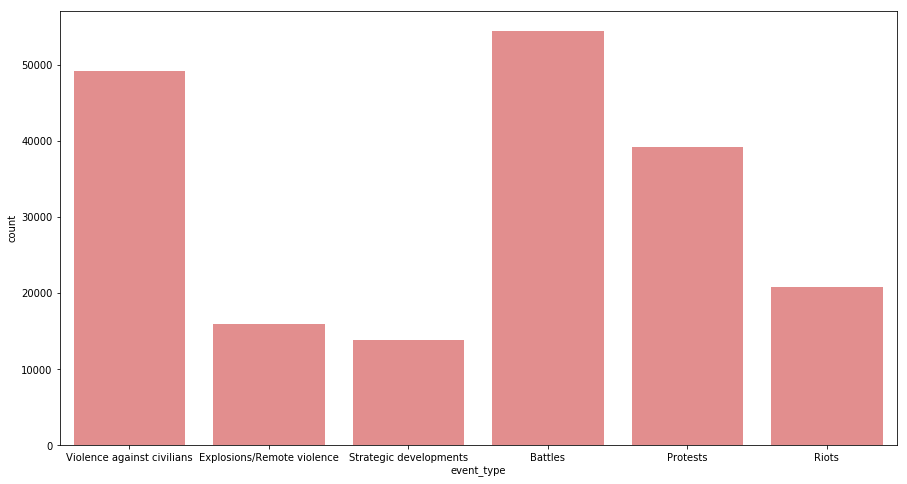

In [24]:
# Events
sns.countplot(x='event_type', color='lightcoral', data=df)

1997-2019 - Number of events in 49 countries: 193565


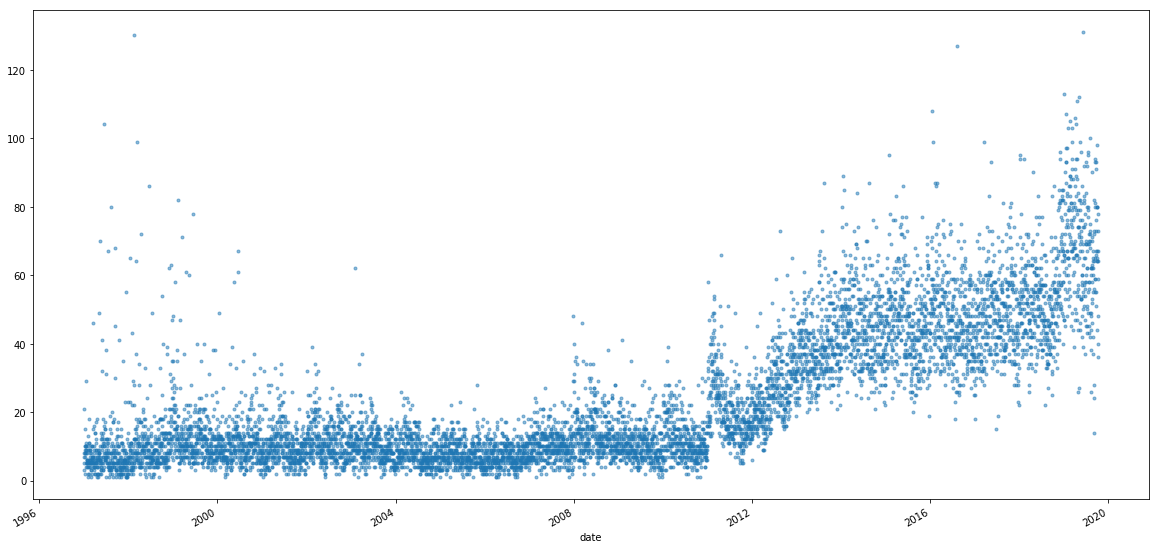

In [25]:
# Plotting time series
# https://www.kaggle.com/lordkada/acled-simple-analysis

# All event 1997 - 2019
event_type = df.groupby(['date'])['event_type'].count()
event_type.plot(subplots=True, figsize=(20, 10), style='.', alpha=0.5)
print("1997-2019 - Number of events in {} countries: {}".
      format(df['country'].nunique(), df['event_type'].count()))

In [26]:
# All subevents by date
sub_events = df.groupby(['date', 'sub_event_type'])['sub_event_type', ].count()
sub_events.reset_index(level=['date'], inplace= True)
sub_events.head()

,date,sub_event_type
sub_event_type,,
Armed clash,1997-01-01,9
Attack,1997-01-01,5
Government regains territory,1997-01-01,1
Headquarters or base established,1997-01-01,2
Looting/property destruction,1997-01-01,3


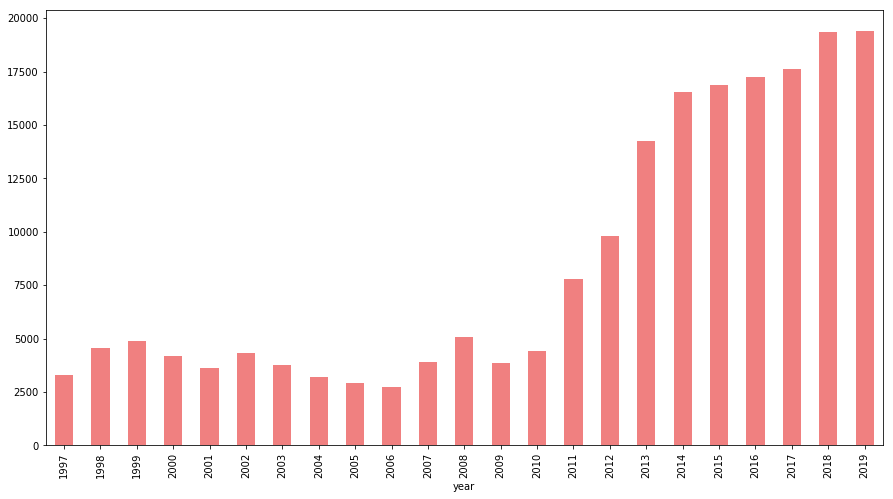

In [27]:
year = df.groupby(['year'])['event_type'].count()
year.plot(kind='bar', color = 'lightcoral')

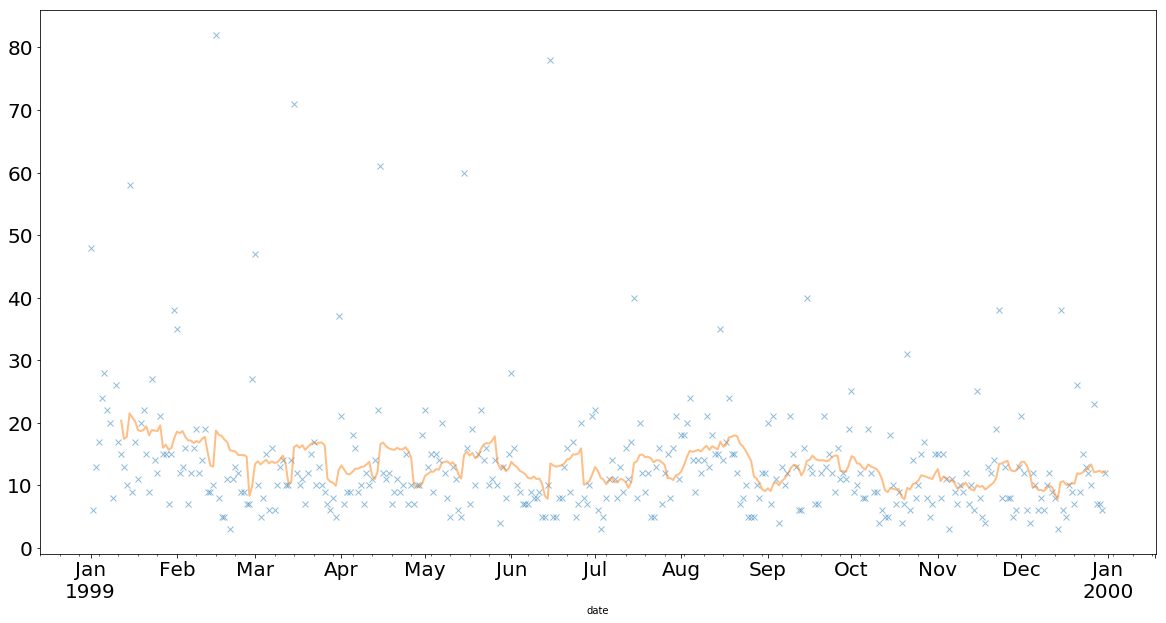

In [80]:
# Use rolling to deseasonalize data 
event_type['1999'].plot(figsize=(20,10), linewidth=5, fontsize=20, style='x', alpha = 0.5)
event_type['1999'].rolling(12).mean().plot(figsize=(20,10), linewidth=2, fontsize=20, alpha = 0.5)


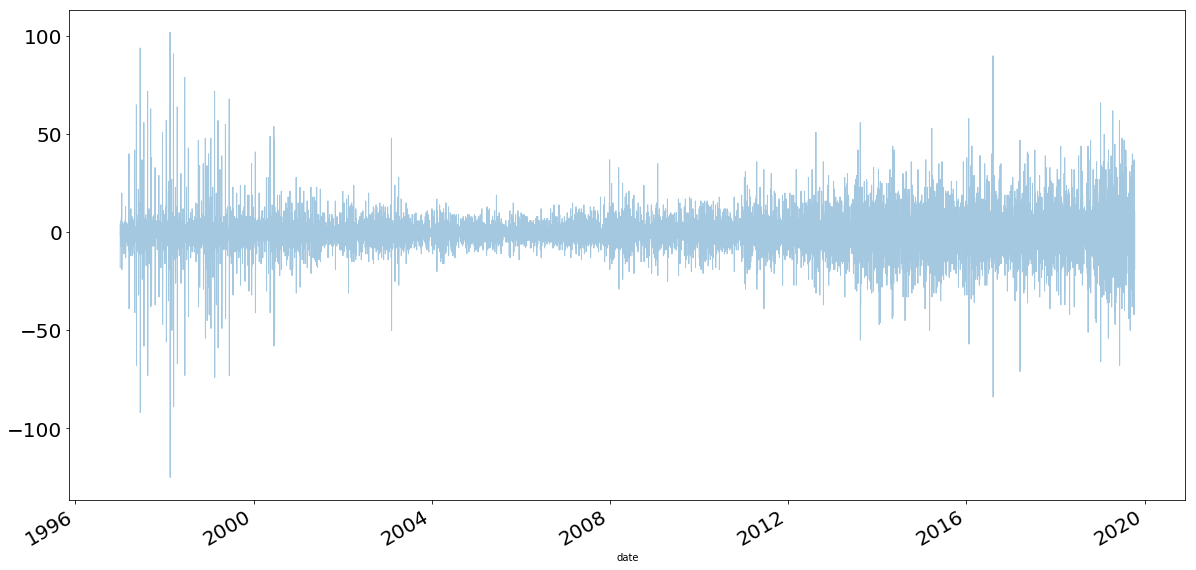

In [83]:
# Plot peaks/diff in data
# event_type.plot(figsize=(20,10), linewidth=5, fontsize=20, style='.', alpha=0.1 )
event_type.diff().plot(figsize=(20,10), linewidth=1, fontsize=20, alpha=0.4 )

# Models: Finding outliers by month

In [ ]:
# Using k-clustering to find anomalies compare to previous month
# https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46